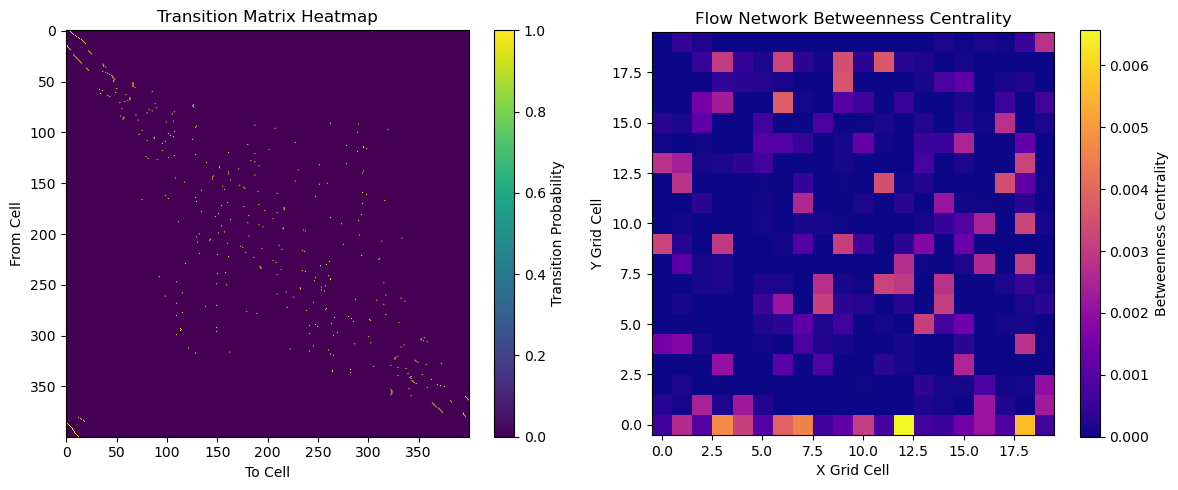

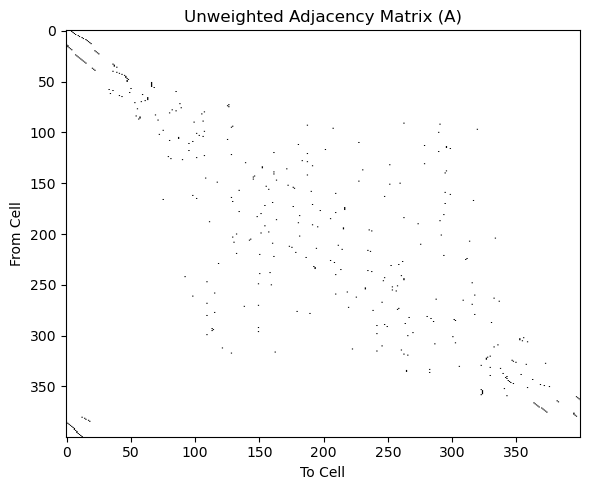

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# defining the velocity field 
def vortex_velocity(x, y, t, A=8.35, B=-2.55, e=0.2):
    u = A * (1 + e * np.sin(np.pi * t)) * np.cos(y) + B * np.sin(2 * x) * np.cos(y)
    v = -2 * B * np.cos(2 * x) * np.sin(y)
    return u, v

# using the runge kutta method to solve the differential equation
def rk4_step(pos, t, dt):
    x, y = pos
    u1, v1 = vortex_velocity(x, y, t)
    u2, v2 = vortex_velocity(x + 0.5*dt*u1, y + 0.5*dt*v1, t + 0.5*dt)
    u3, v3 = vortex_velocity(x + 0.5*dt*u2, y + 0.5*dt*v2, t + 0.5*dt)
    u4, v4 = vortex_velocity(x + dt*u3, y + dt*v3, t + dt)
    
    x_new = x + dt * (u1 + 2*u2 + 2*u3 + u4) / 6
    y_new = y + dt * (v1 + 2*v2 + 2*v3 + v4) / 6
    
    # Apply periodic boundary conditions
    x_new = x_new % np.pi
    y_new = y_new % np.pi
    
    return x_new, y_new

# setting up the grid
nx_cells, ny_cells = 20, 20  # adjust for resolution
x_vals = np.linspace(0, np.pi, nx_cells)
y_vals = np.linspace(0, np.pi, ny_cells)
X, Y = np.meshgrid(x_vals, y_vals)
positions = np.vstack([X.ravel(), Y.ravel()]).T  # shape: (N, 2)

N = nx_cells * ny_cells
transition_matrix = np.zeros((N, N))

#setting up the time frame
dt = 0.1
s = 2.0
steps = int(s / dt)

for i, (x0, y0) in enumerate(positions):
    x, y = x0, y0
    for _ in range(steps):
        x, y = rk4_step((x, y), t=0, dt=dt)
    
    
    xi = int(np.floor((x / np.pi) * nx_cells)) % nx_cells
    yi = int(np.floor((y / np.pi) * ny_cells)) % ny_cells
    j = yi * nx_cells + xi
    transition_matrix[i, j] += 1

# constructing the weighted adjancey matrix and the unweighted adjancy matrix
row_sums = transition_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
T = transition_matrix / row_sums
A = (T > 0).astype(int)

#build network
G = nx.DiGraph()
for i in range(N):
    for j in range(N):
        if T[i, j] > 0:
            G.add_edge(i, j, weight=T[i, j])

# weighted betweenness centrality
centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)
centrality_arr = np.array([centrality.get(i, 0) for i in range(N)])
centrality_grid = centrality_arr.reshape((ny_cells, nx_cells))

plt.figure(figsize=(12, 5))

# Transition Matrix Heatmap
plt.subplot(1, 2, 1)
plt.imshow(T, cmap='viridis', aspect='auto')
plt.colorbar(label="Transition Probability")
plt.title("Transition Matrix Heatmap")
plt.xlabel("To Cell")
plt.ylabel("From Cell")

# Centrality Heatmap
plt.subplot(1, 2, 2)
plt.imshow(centrality_grid, cmap='plasma', origin='lower')
plt.colorbar(label="Betweenness Centrality")
plt.title("Flow Network Betweenness Centrality")
plt.xlabel("X Grid Cell")
plt.ylabel("Y Grid Cell")

plt.tight_layout()
plt.show()
# building the unweighted adjancey matrix
plt.figure(figsize=(6, 5))
plt.imshow(A, cmap='gray_r', aspect='auto')

plt.title("Unweighted Adjacency Matrix (A)")
plt.xlabel("To Cell")
plt.ylabel("From Cell")
plt.tight_layout()
plt.show()
